In [75]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

In [76]:
class BaseModel:  
  lines=[]
  input_words = []
  output_words = []
  chars = set()
  nb_samples = 0

  index_to_char_dict = {}
  char_to_index_dict = {}
  max_len_input_words = 0
  max_len_output_words = 0
  tokenized_input_words=[]
  tokenized_output_words=[]
  target_data=[]
  def __init__(self,inputWords,outputWords):
    self.nb_samples=len(inputWords)
    self.input_words=inputWords
    self.output_words=outputWords
    self.__modifyOutputChars();
    self.__getCharsFromWords();
    self.__setDictionaries();
    self.max_len_input_words = max([len(line) for line in self.input_words])
    self.max_len_output_words = max([len(line) for line in self.output_words])
    self.tokenized_input_words = np.zeros(shape = (self.nb_samples,self.max_len_input_words,len(self.chars)), dtype='float32')
    self.tokenized_output_words = np.zeros(shape = (self.nb_samples,self.max_len_output_words,len(self.chars)), dtype='float32')
    self.target_data = np.zeros((self.nb_samples, self.max_len_output_words, len(self.chars)),dtype='float32')
    self.__tokenizeData();

  def __modifyOutputChars(self):
    self.output_words=['\t'+line+'\n' for line in self.output_words]   


  def __getCharsFromWords(self):

    for line in range(self.nb_samples):
      input_word = self.input_words[line]    
      output_word = self.output_words[line]

      for ch in input_word:
        if (ch not in self.chars):
          self.chars.add(ch)

      for ch in output_word:
        if (ch not in self.chars):
          self.chars.add(ch)

  def __setDictionaries(self):
    self.chars = sorted(list(self.chars))
    for k, v in enumerate(self.chars):
      self.index_to_char_dict[k] = v
      self.char_to_index_dict[v] = k

  def __tokenizeData(self):
    for i in range(self.nb_samples):
      for k,ch in enumerate(self.input_words[i]):
        self.tokenized_input_words[i,k,self.char_to_index_dict[ch]] = 1
        
        for k,ch in enumerate(self.output_words[i]):
          self.tokenized_output_words[i,k,self.char_to_index_dict[ch]] = 1
        
          if k > 0:
            self.target_data[i,k-1,self.char_to_index_dict[ch]] = 1


    


In [77]:
class Char2CharNet:
  dataModel={}
  model={}
  encoder_model_inf={}
  history={}
  chars=0
  def __init__(self,dataModel):   
    self.chars=dataModel.chars 
    self.dataModel=dataModel
    encoder_input = Input(shape=(None,len(dataModel.chars)))
    encoder_LSTM = LSTM(100,return_state = True)
    encoder_outputs, encoder_h, encoder_c = encoder_LSTM (encoder_input)
    encoder_states = [encoder_h, encoder_c]

    decoder_input = Input(shape=(None,len(dataModel.chars)))
    decoder_LSTM = LSTM(100,return_sequences=True, return_state = True)
    decoder_out, _ , _ = decoder_LSTM(decoder_input, initial_state=encoder_states)
    decoder_dense = Dense(len(dataModel.chars),activation='softmax')
    decoder_out = decoder_dense (decoder_out)
    self.model = Model(inputs=[encoder_input, decoder_input],outputs=[decoder_out])
    
    
    self.encoder_model_inf = Model(encoder_input, encoder_states)

    decoder_state_input_h = Input(shape=(100,))
    decoder_state_input_c = Input(shape=(100,))
    decoder_input_states = [decoder_state_input_h, decoder_state_input_c]

    decoder_out, decoder_h, decoder_c = decoder_LSTM(decoder_input, initial_state=decoder_input_states)
    decoder_states = [decoder_h , decoder_c]
    decoder_out = decoder_dense(decoder_out)
    self.decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states, outputs=[decoder_out] + decoder_states )
 
  def trainModel(self):
      
    self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    self.history=self.model.fit(x=[self.dataModel.tokenized_input_words,self.dataModel.tokenized_output_words], 
          y=self.dataModel.target_data,
          batch_size=64,
          epochs=60,
          validation_split=0.15)
    
  def plotLoss(self):
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

  def plotAccuracy(self):
    plt.plot(self.history.history['accuracy'])
    plt.plot(self.history.history['val_accuracy'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

  def decode_seq(self,inp_seq):
    test = np.zeros(shape = (1,self.dataModel.max_len_input_words,len(self.chars)), dtype='float32')
    for k,ch in enumerate(inp_seq):
        test[0,k,self.dataModel.char_to_index_dict[ch]] = 1
  
    states_val = self.encoder_model_inf.predict(test)  
    target_seq = np.zeros((1, 1, len(self.chars)))
    target_seq[0, 0, self.dataModel.char_to_index_dict['\t']] = 1
    translated_sent = ''
    stop_condition = False

    while not stop_condition:        
        decoder_out, decoder_h, decoder_c = self.decoder_model_inf.predict(x=[target_seq] + states_val)        
        max_val_index = np.argmax(decoder_out[0,-1,:])
        sampled_pol_char = self.dataModel.index_to_char_dict[max_val_index]
        translated_sent += sampled_pol_char
        
        if ( (sampled_pol_char == '\n') or (len(translated_sent) > self.dataModel.max_len_output_words)) :
            stop_condition = True
        
        target_seq = np.zeros((1, 1, len(self.chars)))
        target_seq[0, 0, max_val_index] = 1
        
        states_val = [decoder_h, decoder_c]  
    translated_sent = translated_sent[:-1]   
    return translated_sent

In [78]:
class ProjectML():
  maleModel= BaseModel
  maleNet=Char2CharNet

  femaleModel= BaseModel  
  femaleNet=Char2CharNet

  def __init__(self):    
    lines = open('derywaty.txt', encoding='utf-8').read().split('\n')
    female_words = []
    male_words = [] 
    for line in range(len(lines)-1):
      female_word = str(lines[line]).split('\t')[0]    
      male_word = str(lines[line]).split('\t')[1]
      female_words.append(female_word)
      male_words.append(male_word)

    self.maleModel= BaseModel(female_words,male_words)
    self.maleNet=Char2CharNet(self.maleModel);

    self.femaleModel= BaseModel(male_words,female_words)
    self.femaleNet=Char2CharNet(self.femaleModel);

  def TrainMaleModel(self):
    self.maleNet.trainModel()    

  def TrainFemaleModels(self):
    self.femaleNet.trainModel()



In [79]:
mod=ProjectML()


In [80]:
mod.TrainMaleModel()


Train on 2793 samples, validate on 493 samples
Epoch 1/60
2793/2793 [==============================] - 8s 3ms/step - loss: 1.2106 - accuracy: 0.0460 - val_loss: 1.0817 - val_accuracy: 0.0531
Epoch 2/60
2793/2793 [==============================] - 7s 3ms/step - loss: 1.0379 - accuracy: 0.0565 - val_loss: 1.0648 - val_accuracy: 0.0606
Epoch 3/60
2793/2793 [==============================] - 7s 3ms/step - loss: 1.0218 - accuracy: 0.0609 - val_loss: 1.0497 - val_accuracy: 0.0581
Epoch 4/60
2793/2793 [==============================] - 7s 3ms/step - loss: 1.0025 - accuracy: 0.0630 - val_loss: 1.0258 - val_accuracy: 0.0681
Epoch 5/60
2793/2793 [==============================] - 7s 3ms/step - loss: 0.9787 - accuracy: 0.0738 - val_loss: 0.9975 - val_accuracy: 0.0767
Epoch 6/60
2793/2793 [==============================] - 7s 3ms/step - loss: 0.9494 - accuracy: 0.0828 - val_loss: 0.9638 - val_accuracy: 0.0872
Epoch 7/60
2793/2793 [==============================] - 7s 2ms/step - loss: 0.9156 - accu

In [81]:
mod.TrainFemaleModels()


Train on 2793 samples, validate on 493 samples
Epoch 1/60
2793/2793 [==============================] - 8s 3ms/step - loss: 1.2061 - accuracy: 0.0581 - val_loss: 1.0411 - val_accuracy: 0.0731
Epoch 2/60
2793/2793 [==============================] - 7s 3ms/step - loss: 0.9935 - accuracy: 0.0682 - val_loss: 1.0111 - val_accuracy: 0.0738
Epoch 3/60
2793/2793 [==============================] - 7s 3ms/step - loss: 0.9669 - accuracy: 0.0796 - val_loss: 0.9825 - val_accuracy: 0.0860
Epoch 4/60
2793/2793 [==============================] - 7s 3ms/step - loss: 0.9296 - accuracy: 0.0962 - val_loss: 0.9360 - val_accuracy: 0.1033
Epoch 5/60
2793/2793 [==============================] - 7s 3ms/step - loss: 0.8817 - accuracy: 0.1148 - val_loss: 0.8809 - val_accuracy: 0.1221
Epoch 6/60
2793/2793 [==============================] - 7s 3ms/step - loss: 0.8302 - accuracy: 0.1260 - val_loss: 0.8347 - val_accuracy: 0.1303
Epoch 7/60
2793/2793 [==============================] - 7s 3ms/step - loss: 0.7962 - accu

In [85]:
print(mod.maleNet.decode_seq("doktorantka"))
print(mod.femaleNet.decode_seq("aptekarz"))



doktorniate
aptekarka


male Net


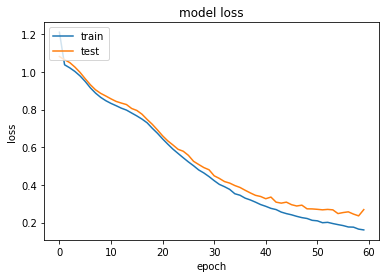

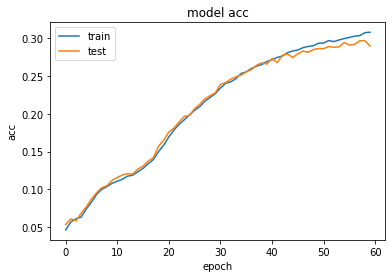

female Net


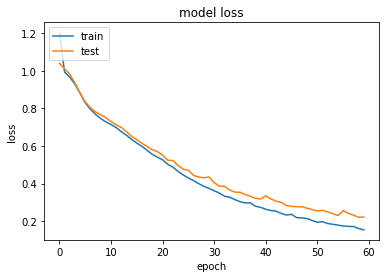

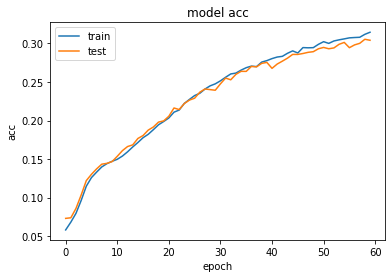

In [83]:
import matplotlib.pyplot as plt
print('male Net')
mod.maleNet.plotLoss()
mod.maleNet.plotAccuracy()

print('female Net')
mod.femaleNet.plotLoss()
mod.femaleNet.plotAccuracy()

